In [5]:
using NeuralPDE, Lux, LuxCUDA, Random, ComponentArrays
using Optimization
using OptimizationOptimisers
import ModelingToolkit
using IntervalSets
using Plots
using Printf

const gpud = gpu_device()

@parameters t x y
@variables u(..)
Dxx = Differential(x)^2
Dyy = Differential(y)^2
Dt = Differential(t)
t_min = 0.0
t_max = 2.0
x_min = 0.0
x_max = 2.0
y_min = 0.0
y_max = 2.0

# 2D PDE
eq = Dt(u(t, x, y)) ~ Dxx(u(t, x, y)) + Dyy(u(t, x, y))

analytic_sol_func(t, x, y) = exp(x + y) * cos(x + y + 4t)
# Initial and boundary conditions
bcs = [u(t_min, x, y) ~ analytic_sol_func(t_min, x, y),
    u(t, x_min, y) ~ analytic_sol_func(t, x_min, y),
    u(t, x_max, y) ~ analytic_sol_func(t, x_max, y),
    u(t, x, y_min) ~ analytic_sol_func(t, x, y_min),
    u(t, x, y_max) ~ analytic_sol_func(t, x, y_max)]

# Space and time domains
domains = [t ∈ Interval(t_min, t_max),
    x ∈ Interval(x_min, x_max),
    y ∈ Interval(y_min, y_max)]

# Neural network
inner = 25
chain = Chain(Dense(3, inner, σ), Dense(inner, inner, σ), Dense(inner, inner, σ),
    Dense(inner, inner, σ), Dense(inner, 1))

strategy = QuasiRandomTraining(100)
ps = Lux.setup(Random.default_rng(), chain)[1]
ps = ps |> ComponentArray |> gpud .|> Float64
discretization = PhysicsInformedNN(chain, strategy; init_params = ps)

@named pde_system = PDESystem(eq, bcs, domains, [t, x, y], [u(t, x, y)])
prob = discretize(pde_system, discretization)
symprob = symbolic_discretize(pde_system, discretization)

callback = function (p, l)
    println("Current loss is: $l")
    return false
end

res = Optimization.solve(prob, OptimizationOptimisers.Adam(1e-2); maxiters = 2500)

retcode: Default
u: ComponentVector{Float64, CuArray{Float64, 1, CUDA.DeviceMemory}, Tuple{Axis{(layer_1 = ViewAxis(1:100, Axis(weight = ViewAxis(1:75, ShapedAxis((25, 3))), bias = ViewAxis(76:100, Shaped1DAxis((25,))))), layer_2 = ViewAxis(101:750, Axis(weight = ViewAxis(1:625, ShapedAxis((25, 25))), bias = ViewAxis(626:650, Shaped1DAxis((25,))))), layer_3 = ViewAxis(751:1400, Axis(weight = ViewAxis(1:625, ShapedAxis((25, 25))), bias = ViewAxis(626:650, Shaped1DAxis((25,))))), layer_4 = ViewAxis(1401:2050, Axis(weight = ViewAxis(1:625, ShapedAxis((25, 25))), bias = ViewAxis(626:650, Shaped1DAxis((25,))))), layer_5 = ViewAxis(2051:2076, Axis(weight = ViewAxis(1:25, ShapedAxis((1, 25))), bias = ViewAxis(26:26, Shaped1DAxis((1,))))))}}}(layer_1 = (weight = [-2.8074268185975115 0.05828011417733123 0.03573235930810567; -1.2130633835039246 0.37420464557064853 0.6448629848441698; … ; -1.6304387765496176 -0.4782991064557011 -0.4857638775535546; 3.8440589806461327 -0.2807541198995354 -0.371381

In [6]:
prob = remake(prob, u0 = res.u)
res = Optimization.solve(
    prob, OptimizationOptimisers.Adam(1e-3); callback = callback, maxiters = 2500)

Current loss is: 113.4884981004009
Current loss is: 102.77519800173827
Current loss is: 113.54151005361038
Current loss is: 127.93470223731629
Current loss is: 151.96758974845318
Current loss is: 136.2750126438366
Current loss is: 91.70136631153639
Current loss is: 78.65812982453733
Current loss is: 150.37090524441226
Current loss is: 96.35003592247539
Current loss is: 128.05976510398446
Current loss is: 91.7932135313043
Current loss is: 143.06557772106467
Current loss is: 124.42972592305456
Current loss is: 112.53576976428876
Current loss is: 107.98186192760583
Current loss is: 130.60135472989566
Current loss is: 104.9793684986554
Current loss is: 82.06638193011504
Current loss is: 121.41881844274005
Current loss is: 108.21672422253297
Current loss is: 126.71913213166758
Current loss is: 77.45325067947871
Current loss is: 98.97087046502172
Current loss is: 171.46866211087075
Current loss is: 93.64398384784879
Current loss is: 95.69924845462789
Current loss is: 116.30267072184526
Curre

retcode: Default
u: ComponentVector{Float64, CuArray{Float64, 1, CUDA.DeviceMemory}, Tuple{Axis{(layer_1 = ViewAxis(1:100, Axis(weight = ViewAxis(1:75, ShapedAxis((25, 3))), bias = ViewAxis(76:100, Shaped1DAxis((25,))))), layer_2 = ViewAxis(101:750, Axis(weight = ViewAxis(1:625, ShapedAxis((25, 25))), bias = ViewAxis(626:650, Shaped1DAxis((25,))))), layer_3 = ViewAxis(751:1400, Axis(weight = ViewAxis(1:625, ShapedAxis((25, 25))), bias = ViewAxis(626:650, Shaped1DAxis((25,))))), layer_4 = ViewAxis(1401:2050, Axis(weight = ViewAxis(1:625, ShapedAxis((25, 25))), bias = ViewAxis(626:650, Shaped1DAxis((25,))))), layer_5 = ViewAxis(2051:2076, Axis(weight = ViewAxis(1:25, ShapedAxis((1, 25))), bias = ViewAxis(26:26, Shaped1DAxis((1,))))))}}}(layer_1 = (weight = [-2.843838655388571 0.0688973172400429 0.047461268721144347; -1.2346362766843169 0.37863404111510895 0.6455215998843757; … ; -1.6791838665110481 -0.4813467087035086 -0.4887720994682345; 3.885971671761356 -0.2907108853196588 -0.37387010

┌ Warning: Mixed Precision Inputs received for `weight`: CuArray{Float64, 2, CUDA.DeviceMemory} and `x`: CuArray{Float32, 2, CUDA.DeviceMemory}. Promoting to Float64.
└ @ LuxLibCUDAExt /users/oreula/.julia/packages/LuxLib/R8Czx/ext/LuxLibCUDAExt/cublaslt.jl:41
┌ Info: Animating frame 1...
└ @ Main /users/oreula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sdnNjb2RlLXJlbW90ZQ==.jl:9
┌ Info: Animating frame 2...
└ @ Main /users/oreula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sdnNjb2RlLXJlbW90ZQ==.jl:9
┌ Info: Animating frame 3...
└ @ Main /users/oreula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sdnNjb2RlLXJlbW90ZQ==.jl:9
┌ Info: Animating frame 4...
└ @ Main /users/oreula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sdnNjb2RlLXJlbW90ZQ==.jl:9
┌ Info: Animating frame 5...
└ @ Main /users/oreula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sdnNjb2RlLXJlbW90ZQ==.jl:9
┌ Info: Animating frame 6...


Plots.AnimatedGif("/users/oreula/Julia/PINN/3pde.gif")
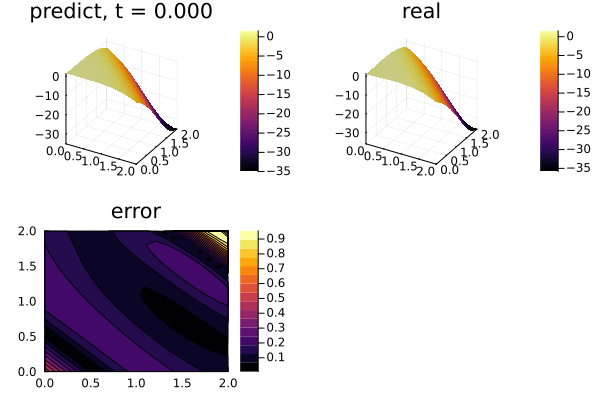

In [7]:
phi = discretization.phi
ts, xs, ys = [infimum(d.domain):0.1:supremum(d.domain) for d in domains]
u_real = [analytic_sol_func(t, x, y) for t in ts for x in xs for y in ys]
u_predict = [first(Array(phi([t, x, y], res.u))) for t in ts for x in xs for y in ys]

function plot_(res)
    # Animate
    anim = @animate for (i, t) in enumerate(0:0.05:t_max)
        @info "Animating frame $i..."
        u_real = reshape([analytic_sol_func(t, x, y) for x in xs for y in ys],
            (length(xs), length(ys)))
        u_predict = reshape([Array(phi([t, x, y], res.u))[1] for x in xs for y in ys],
            length(xs), length(ys))
        u_error = abs.(u_predict .- u_real)
        title = @sprintf("predict, t = %.3f", t)
        p1 = plot(xs, ys, u_predict, st = :surface, label = "", title = title)
        title = @sprintf("real")
        p2 = plot(xs, ys, u_real, st = :surface, label = "", title = title)
        title = @sprintf("error")
        p3 = plot(xs, ys, u_error, st = :contourf, label = "", title = title)
        plot(p1, p2, p3)
    end
    gif(anim, "3pde.gif", fps = 10)
end

plot_(res)